# Run

In [40]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import onnxruntime as ort
import pandas as pd
from PIL import Image


def cosine_similarity(feature1, feature2):
    return np.dot(feature1, feature2) / (np.linalg.norm(feature1) * np.linalg.norm(feature2))


def similarity(feature1, feature2):
    return (cosine_similarity(feature1, feature2) + 1) / 2


def pad2square(pil_image: Image.Image, pad_value: int = 0) -> np.ndarray:
    image = np.array(pil_image)
    h, w = image.shape[:2]
    if h == w:
        return pil_image
    size = max(h, w)
    top = (size - h) // 2
    left = (size - w) // 2
    image = cv2.copyMakeBorder(
        image,
        top,
        size - h - top,
        left,
        size - w - left,
        cv2.BORDER_CONSTANT,
        value=pad_value,
    )
    return Image.fromarray(image)

In [41]:
model_path = "../models/clf.onnx"

sess_options = ort.SessionOptions()
sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_EXTENDED

session = ort.InferenceSession(
    model_path,
    sess_options=sess_options,
    providers=["CUDAExecutionProvider", "CPUExecutionProvider"],
)
input_name = session.get_inputs()[0].name
input_shape = session.get_inputs()[0].shape

same image 1.0
same labels 0.8986132
different labels 0.50377494


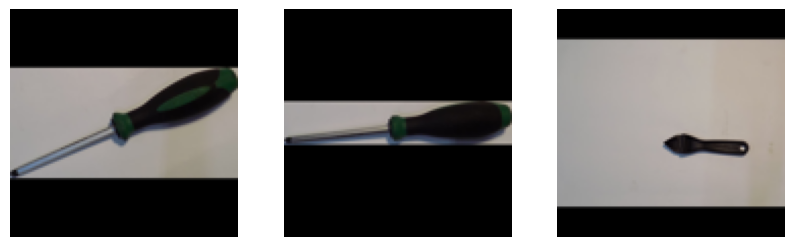

In [43]:
root = Path("/home/akobylin/datasets/lct_2025")
df = pd.read_csv("annotations.csv")
labels = set(np.unique(df.label.values))

label1 = np.random.choice(list(labels))
labels.remove(label1)
label2 = np.random.choice(list(labels))

df1 = df[df.label == label1]
df2 = df[df.label == label2]

idx1 = np.random.randint(0, df1.shape[0] - 1)
idx2 = np.random.randint(0, df1.shape[0] - 1)
idx3 = np.random.randint(0, df2.shape[0] - 1)

row1 = df1.iloc[idx1]
row2 = df1.iloc[idx2]
row3 = df2.iloc[idx3]

image1 = Image.open(root / row1["label"] / row1["path"]).convert("RGB")
image1 = image1.crop((row1["x0"], row1["y0"], row1["x1"], row1["y1"]))
image1 = pad2square(image1)
image1 = image1.resize((112, 112))
image2 = Image.open(root / row2["label"] / row2["path"]).convert("RGB")
image2 = image2.crop((row2["x0"], row2["y0"], row2["x1"], row2["y1"]))
image2 = pad2square(image2)
image2 = image2.resize((112, 112))
image3 = Image.open(root / row3["label"] / row3["path"]).convert("RGB")
image3 = image3.crop((row3["x0"], row3["y0"], row3["x1"], row3["y1"]))
image3 = pad2square(image3)
image3 = image3.resize((112, 112))

p1 = session.run(["feature"], {input_name: np.array(image1)[None, ...]})[0][0]
p2 = session.run(["feature"], {input_name: np.array(image2)[None, ...]})[0][0]
p3 = session.run(["feature"], {input_name: np.array(image3)[None, ...]})[0][0]
print("same image", similarity(p1, p1))
print("same labels", similarity(p1, p2))
print("different labels", similarity(p1, p3))

plt.figure(figsize=(10, 30))
plt.subplot(1, 3, 1)
plt.imshow(image1)
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(image2)
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(image3)
plt.axis("off")
plt.show()